In [1]:
import sys
# import sibling folder
sys.path.append("..")

In [2]:
import os
import numpy as np
import pandas as pd
from llama_cpp import Llama
from datasets import load_from_disk

import experiments.utils as utils
from pprint import pprint
from IPython.display import display_markdown

In [3]:
!pwd

/Users/mahat/Desktop/Dev/JB_Project/sentiment-analysis/notebooks


In [4]:
# init datasets
valid_ds_mini = load_from_disk('../data/valid_mini.hf')

valid_ds_small = load_from_disk('../data/valid_small.hf')
incontext_ds_small = load_from_disk('../data/incontext_small.hf')

valid_ds_big = load_from_disk('../data/valid_big.hf')
incontext_ds_big = load_from_disk('../data/incontext_big.hf')

# model names
small_model_repo_id="bartowski/Qwen2.5-0.5B-Instruct-GGUF"
small_model_file_name="Qwen2.5-0.5B-Instruct-IQ2_M.gguf"

big_model_repo_id="bartowski/Qwen2.5-1.5B-Instruct-GGUF"
big_model_file_name="Qwen2.5-1.5B-Instruct-IQ2_M.gguf"

In [60]:
def temp_check_helper(model,trange=np.arange(0.2,1.4,0.2)):
    metrics = []
    ta_func = lambda p,l: (np.array(p) == np.array(l)).sum() / len(l)
    for t in trange:
        print(t)
        model.temperature = t
        metric = model().eval()
        metric['temp'] = t
        metric['acc'] = ta_func(model.preds,model.labels)
        metrics.append(metric)
    return metrics

In [61]:
def minP_check_helper(model,temp=0.2,prange=np.arange(0.05,0.6,0.05)):
    ta_func = lambda p,l: (np.array(p) == np.array(l)).sum() / len(l)
    metrics = []
    for p in prange:
        print(p)
        # update temp
        model.temperature = temp
        model.min_p = p
        # run experiment
        metric = model().eval()
        metric['min_p'] = p
        metric['acc'] = ta_func(model.preds,model.labels)
        metrics.append(metric)
    return metrics

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_metrics(metric_list,x_key,y_key,title=""):
    fig = plt.figure()
    y = [e[y_key] for e in metric_list]
    x = [e[x_key] for e in metric_list]
    ax = sns.lineplot(x=x,y=y)
    ax.set_title(title)
    ax.set_xlabel(x_key)
    ax.set_ylabel(y_key)
    return fig


In [77]:
# setup big model
big_llm = Llama.from_pretrained(
    repo_id=big_model_repo_id,
    filename=big_model_file_name,
    n_ctx = 4096,
    verbose=False,
    seed=42,
)


llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

## Simple Prompt Experiment

In [6]:
# experiment init
from experiments.simple_prompt_experiment import SimplePromptExperiment
simple_prompt_exp  = SimplePromptExperiment(model=big_llm, n_ctx=4096, valid_ds=valid_ds_small)

display_markdown(f"### System and User Prompts", raw=True)
display_markdown(f"**System Prompt**: {simple_prompt_exp.system_prompt}", raw=True)
display_markdown(f"**User Prompt**: {simple_prompt_exp.user_prompt}", raw=True)

### System and User Prompts

**System Prompt**: You are a helpful large language model that understands sentiment of a review inside <review>...</review> tags. 
Your final answer must be either Negative or Positive based on the sentiment of the review.

**User Prompt**: <review>{review}</review> 

Your final answer is

running validation set: 100%|██████████| 128/128 [01:44<00:00,  1.22it/s]

{'accuracy': 0.921875,
 'confusion_matrix': array([[56,  8],
       [ 2, 62]]),
 'f1_score': 0.9253731343283582,
 'precision': 0.8857142857142857,
 'recall': 0.96875,
 'valid_answer_ratio': np.float64(1.0)}


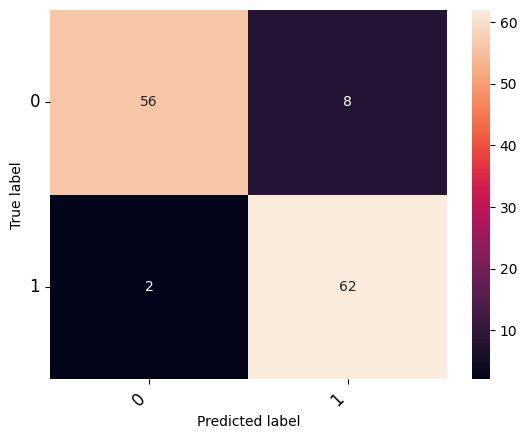

In [7]:
simple_prompt_eval = simple_prompt_exp().eval()
pprint(simple_prompt_eval)
fig=utils.plot_cm(simple_prompt_eval['confusion_matrix'])

In [8]:
# save fig
fig.savefig('../docs/CM_plot_big_model.png')

### Bigger Validation set

running validation set: 100%|██████████| 512/512 [06:41<00:00,  1.28it/s]

{'accuracy': 0.91015625,
 'confusion_matrix': array([[218,  38],
       [  8, 248]]),
 'f1_score': 0.915129151291513,
 'precision': 0.8671328671328671,
 'recall': 0.96875,
 'valid_answer_ratio': np.float64(1.0)}


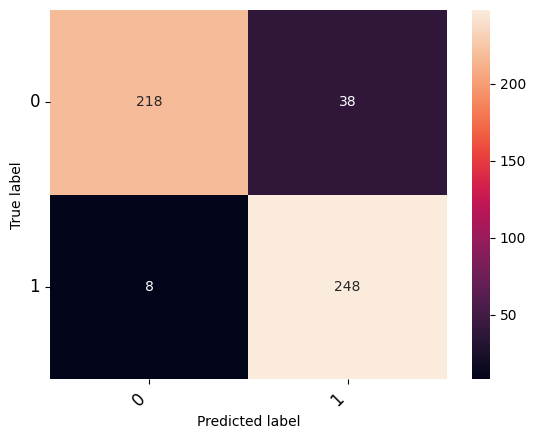

In [9]:
simple_prompt_exp = SimplePromptExperiment(model=big_llm, n_ctx=4096, valid_ds=valid_ds_big)
simple_prompt_eval = simple_prompt_exp().eval()
pprint(simple_prompt_eval)
fig=utils.plot_cm(simple_prompt_eval['confusion_matrix'])
fig.savefig('../docs/cm_plot_simple_prompt_big_model.png')

### Small Model Run for Simple Prompt

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

{'accuracy': 0.8145161290322581,
 'confusion_matrix': array([[58,  4],
       [19, 43]]),
 'f1_score': 0.7889908256880734,
 'precision': 0.9148936170212766,
 'recall': 0.6935483870967742,
 'valid_answer_ratio': np.float64(0.96875)}


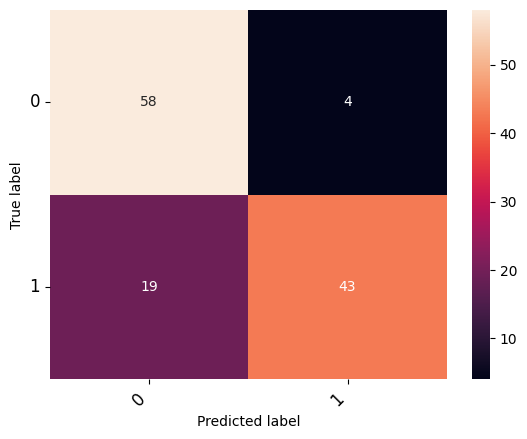

In [14]:
# init small model
small_llm = Llama.from_pretrained(
    repo_id=small_model_repo_id,
    filename=small_model_file_name,
    n_ctx = 4096,
    verbose=False
)
simple_prompt_exp = SimplePromptExperiment(model=small_llm, n_ctx=4096, valid_ds=valid_ds_small)
simple_prompt_eval = simple_prompt_exp().eval()
pprint(simple_prompt_eval)
fig=utils.plot_cm(simple_prompt_eval['confusion_matrix'])
fig.savefig('../docs/cm_plot_simple_prompt_small_model.png')

### Measuring affect of temparature for small model

In [15]:
# set temp to different values
metrics = []
for t in np.arange(0.2,1.4,0.2):
    print(t)
    simple_prompt_exp = SimplePromptExperiment(model=small_llm, n_ctx=4096, valid_ds=valid_ds_mini)
    # update temp
    simple_prompt_exp.temperature = t
    metric = simple_prompt_exp().eval()
    metric['temp'] = t
    metrics.append(metric)

0.2


running validation set: 100%|██████████| 64/64 [00:23<00:00,  2.76it/s]


0.4


running validation set: 100%|██████████| 64/64 [00:23<00:00,  2.67it/s]


0.6000000000000001


running validation set: 100%|██████████| 64/64 [00:23<00:00,  2.76it/s]


0.8


running validation set: 100%|██████████| 64/64 [00:21<00:00,  3.01it/s]


1.0


running validation set: 100%|██████████| 64/64 [00:20<00:00,  3.09it/s]


1.2000000000000002


running validation set: 100%|██████████| 64/64 [00:22<00:00,  2.87it/s]


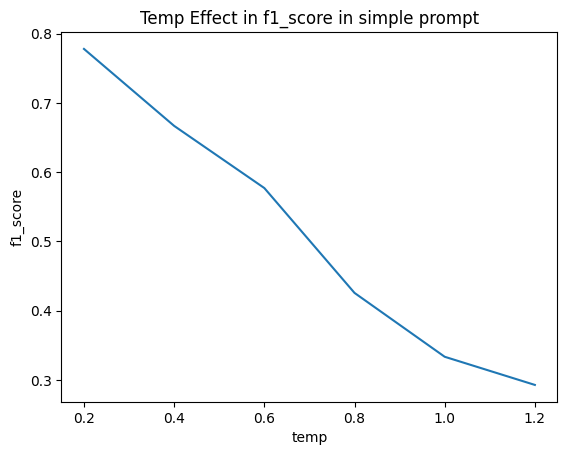

In [ ]:
# plot results
# accuracy
#fig = plot_metrics(metrics,x_key='temp',y_key='accuracy',title='Temp Effect in accuracy')
# f1_score
fig = plot_metrics(metrics,x_key='temp',y_key='f1_score',title='Temp Effect Temp in f1_score in simple prompt')

### Measuring affect of minP

In [33]:
# set temp to different values
metrics = []
for p in np.arange(0.05,0.6,0.05):
    print(p)
    simple_prompt_exp = SimplePromptExperiment(model=small_llm, n_ctx=4096, valid_ds=valid_ds_mini)
    # update minP
    simple_prompt_exp.min_p = p
    metric = simple_prompt_exp().eval()
    metric['min_p'] = p
    metrics.append(metric)

0.05


running validation set: 100%|██████████| 64/64 [00:21<00:00,  2.93it/s]


0.1


running validation set: 100%|██████████| 64/64 [00:23<00:00,  2.73it/s]


0.15000000000000002


running validation set: 100%|██████████| 64/64 [00:20<00:00,  3.14it/s]


0.2


running validation set: 100%|██████████| 64/64 [00:20<00:00,  3.09it/s]


0.25


running validation set: 100%|██████████| 64/64 [00:20<00:00,  3.08it/s]


0.30000000000000004


running validation set: 100%|██████████| 64/64 [00:24<00:00,  2.62it/s]


0.35000000000000003


running validation set: 100%|██████████| 64/64 [00:28<00:00,  2.27it/s]


0.4


running validation set: 100%|██████████| 64/64 [00:25<00:00,  2.55it/s]


0.45


running validation set: 100%|██████████| 64/64 [00:23<00:00,  2.74it/s]


0.5


running validation set: 100%|██████████| 64/64 [00:21<00:00,  2.95it/s]


0.55


running validation set: 100%|██████████| 64/64 [00:22<00:00,  2.89it/s]


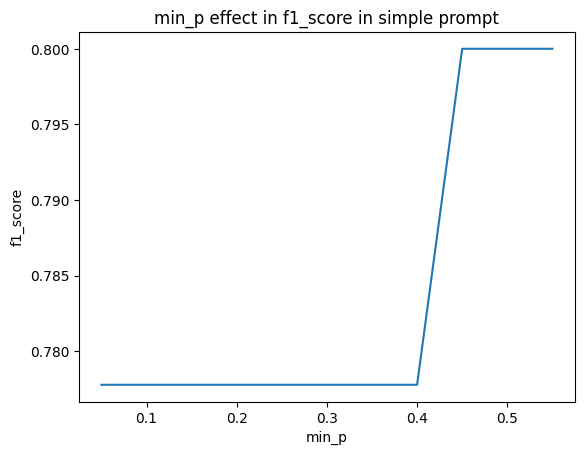

In [37]:
# plot results
# f1 score
fig = plot_metrics(metrics,x_key='min_p',y_key='f1_score',title='min_p effect in f1_score in simple prompt')

In [38]:
metrics[-1]

{'accuracy': 0.819672131147541,
 'recall': 0.7333333333333333,
 'precision': 0.88,
 'f1_score': 0.8,
 'confusion_matrix': array([[28,  3],
        [ 8, 22]]),
 'valid_answer_ratio': np.float64(0.953125),
 'min_p': np.float64(0.55)}

running validation set: 100%|██████████| 512/512 [03:18<00:00,  2.59it/s]

{'accuracy': 0.8230616302186878,
 'confusion_matrix': array([[236,  14],
       [ 75, 178]]),
 'f1_score': 0.8,
 'precision': 0.9270833333333334,
 'recall': 0.7035573122529645,
 'valid_answer_ratio': np.float64(0.982421875)}


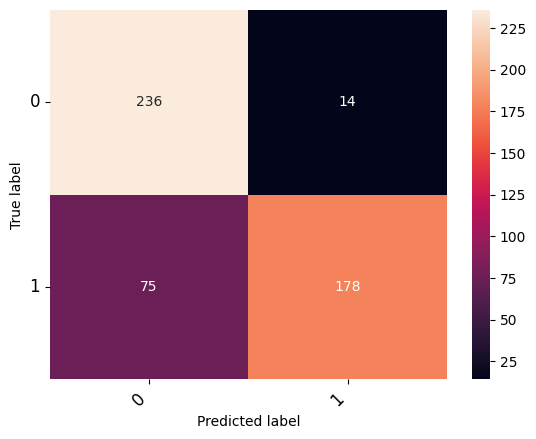

In [41]:
# big val run
simple_prompt_exp = SimplePromptExperiment(model=small_llm, n_ctx=4096, valid_ds=valid_ds_big)
simple_prompt_exp.min_p = 0.45
simple_prompt_eval = simple_prompt_exp().eval()
pprint(simple_prompt_eval)
fig=utils.plot_cm(simple_prompt_eval['confusion_matrix'])
#fig.savefig('../docs/cm_plot_simple_prompt_small_model.png')

In [36]:
# delete experiment
del simple_prompt_exp

## FewShot Learning

In [42]:
from experiments.few_shot_experiment import FewShotExperiment
# increasing n_ctx for bigger few shots
few_shot_exp  = FewShotExperiment(small_model_repo_id, small_model_file_name, n_ctx=1024*5, valid_ds=valid_ds_mini,incoxtext_examples=incontext_ds_small, pass_k=5)
display_markdown(f"### System and User Prompts", raw=True)
display_markdown(f"**System Prompt**: {few_shot_exp.system_prompt}", raw=True)
display_markdown(f"**User Prompt**: {few_shot_exp.user_prompt}", raw=True)

llama_init_from_model: n_ctx_per_seq (5120) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

### System and User Prompts

**System Prompt**: You are a helpful large language model that understands sentiment of a movie review. Examples are provided inside <examples>...</examples> tags as list items <li>...</li> to help you to decide.
Your final answer must be either Negative or Positive based on the sentiment of the review.

**User Prompt**: <examples>
{inContext}
</examples>
Review: {query} Final Answer:

#### HyperParam Search

#### Temp

In [44]:
# set temp to different values
ta_func = lambda p,l: (np.array(p) == np.array(l)).sum() / len(l)
metrics = []
few_shot_exp  = FewShotExperiment(small_model_repo_id, small_model_file_name, n_ctx=1024*5, valid_ds=valid_ds_mini,incoxtext_examples=incontext_ds_small, pass_k=5)
for t in np.arange(0.2,1.4,0.2):
    print(t)
    # update temp
    few_shot_exp.temperature = t
    # run experiment
    metric = few_shot_exp().eval()
    metric['temp'] = t
    metric['acc'] = ta_func(few_shot_exp.preds,few_shot_exp.labels)
    metrics.append(metric)
metrics

llama_init_from_model: n_ctx_per_seq (5120) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

0.2


running validation set: 100%|██████████| 64/64 [02:26<00:00,  2.28s/it]


0.4


running validation set: 100%|██████████| 64/64 [03:23<00:00,  3.18s/it]


0.6000000000000001


running validation set: 100%|██████████| 64/64 [02:30<00:00,  2.34s/it]


0.8


running validation set: 100%|██████████| 64/64 [02:02<00:00,  1.91s/it]


1.0


running validation set: 100%|██████████| 64/64 [02:30<00:00,  2.36s/it]


1.2000000000000002


running validation set: 100%|██████████| 64/64 [02:20<00:00,  2.19s/it]


[{'accuracy': 0.6825396825396826,
  'recall': 0.3870967741935484,
  'precision': 0.9230769230769231,
  'f1_score': 0.5454545454545454,
  'confusion_matrix': array([[31,  1],
         [19, 12]]),
  'valid_answer_ratio': np.float64(0.984375),
  'temp': np.float64(0.2),
  'acc': np.float64(0.671875)},
 {'accuracy': 0.7333333333333333,
  'recall': 0.4827586206896552,
  'precision': 0.9333333333333333,
  'f1_score': 0.6363636363636364,
  'confusion_matrix': array([[30,  1],
         [15, 14]]),
  'valid_answer_ratio': np.float64(0.9375),
  'temp': np.float64(0.4),
  'acc': np.float64(0.6875)},
 {'accuracy': 0.711864406779661,
  'recall': 0.5185185185185185,
  'precision': 0.7777777777777778,
  'f1_score': 0.6222222222222222,
  'confusion_matrix': array([[28,  4],
         [13, 14]]),
  'valid_answer_ratio': np.float64(0.921875),
  'temp': np.float64(0.6000000000000001),
  'acc': np.float64(0.65625)},
 {'accuracy': 0.819672131147541,
  'recall': 0.7,
  'precision': 0.9130434782608695,
  'f1_

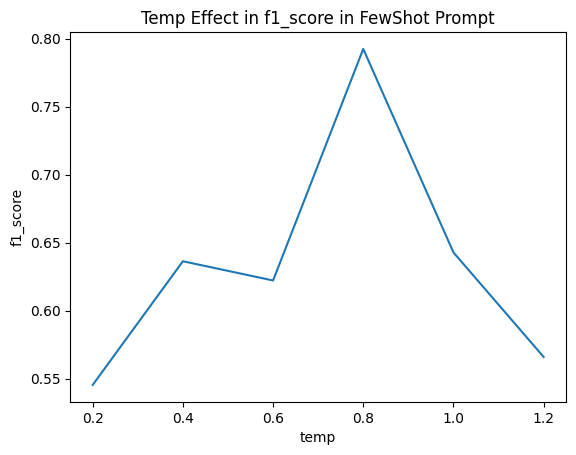

In [45]:
fig = plot_metrics(metrics,x_key='temp',y_key='f1_score',title='Temp Effect in f1_score in FewShot Prompt')

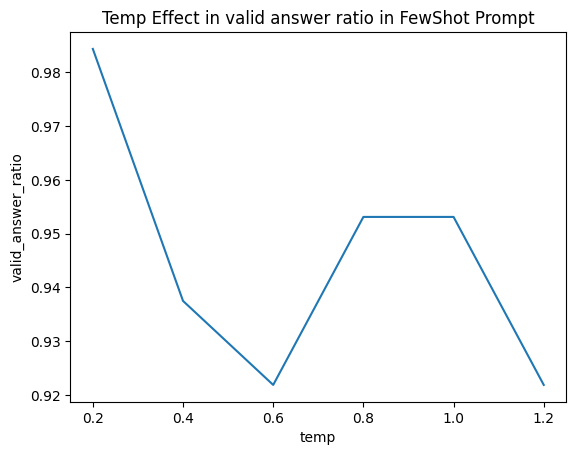

In [46]:
fig = plot_metrics(metrics,x_key='temp',y_key='valid_answer_ratio',title='Temp Effect in valid answer ratio in FewShot Prompt')

In [ ]:
# cheking min_p
# set temp to different values
ta_func = lambda p,l: (np.array(p) == np.array(l)).sum() / len(l)
metrics = []
few_shot_exp  = FewShotExperiment(small_model_repo_id, small_model_file_name, n_ctx=1024*5, valid_ds=valid_ds_mini,incoxtext_examples=incontext_ds_small, pass_k=5)
for p in np.arange(0.05,0.6,0.05):
    print(p)
    # update temp
    few_shot_exp.temperature = 0.8
    few_shot_exp.min_p = p
    # run experiment
    metric = few_shot_exp().eval()
    metric['min_p'] = p
    metric['acc'] = ta_func(few_shot_exp.preds,few_shot_exp.labels)
    metrics.append(metric)
metrics

llama_init_from_model: n_ctx_per_seq (5120) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

0.05


running validation set: 100%|██████████| 64/64 [03:01<00:00,  2.84s/it]


0.1


running validation set: 100%|██████████| 64/64 [02:41<00:00,  2.53s/it]


0.15000000000000002


running validation set: 100%|██████████| 64/64 [02:28<00:00,  2.32s/it]


0.2


running validation set: 100%|██████████| 64/64 [02:17<00:00,  2.15s/it]


0.25


running validation set: 100%|██████████| 64/64 [02:23<00:00,  2.24s/it]


0.30000000000000004


running validation set: 100%|██████████| 64/64 [02:17<00:00,  2.15s/it]


0.35000000000000003


running validation set: 100%|██████████| 64/64 [02:18<00:00,  2.16s/it]


0.4


running validation set: 100%|██████████| 64/64 [02:24<00:00,  2.26s/it]


0.45


running validation set: 100%|██████████| 64/64 [02:20<00:00,  2.20s/it]


0.5


running validation set: 100%|██████████| 64/64 [02:40<00:00,  2.50s/it]


0.55


running validation set: 100%|██████████| 64/64 [02:13<00:00,  2.09s/it]


[{'accuracy': 0.7222222222222222,
  'recall': 0.52,
  'precision': 0.8125,
  'f1_score': 0.6341463414634146,
  'confusion_matrix': array([[26,  3],
         [12, 13]]),
  'valid_answer_ratio': np.float64(0.84375),
  'min_p': np.float64(0.05),
  'acc': np.float64(0.609375)},
 {'accuracy': 0.7454545454545455,
  'recall': 0.5769230769230769,
  'precision': 0.8333333333333334,
  'f1_score': 0.6818181818181818,
  'confusion_matrix': array([[26,  3],
         [11, 15]]),
  'valid_answer_ratio': np.float64(0.859375),
  'min_p': np.float64(0.1),
  'acc': np.float64(0.640625)},
 {'accuracy': 0.8103448275862069,
  'recall': 0.6428571428571429,
  'precision': 0.9473684210526315,
  'f1_score': 0.7659574468085106,
  'confusion_matrix': array([[29,  1],
         [10, 18]]),
  'valid_answer_ratio': np.float64(0.90625),
  'min_p': np.float64(0.15000000000000002),
  'acc': np.float64(0.734375)},
 {'accuracy': 0.7777777777777778,
  'recall': 0.6451612903225806,
  'precision': 0.8695652173913043,
  'f1_s

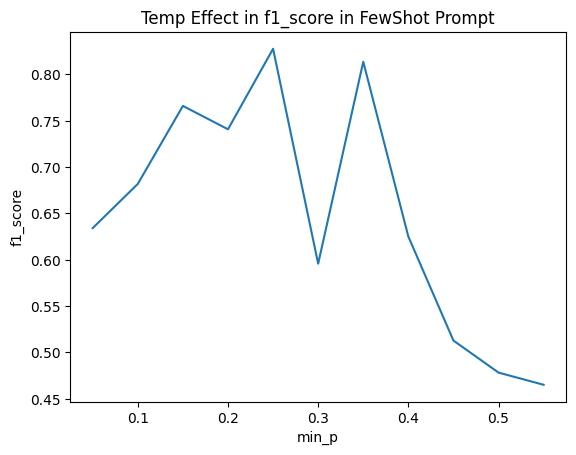

In [ ]:
fig = plot_metrics(metrics,x_key='min_p',y_key='f1_score',title='Param Search FewShot Prompt')

In [ ]:
# increase pass@k and check temparature
few_shot_exp = FewShotExperiment(small_model_repo_id, small_model_file_name, n_ctx=1024*8, valid_ds=valid_ds_mini,incoxtext_examples=incontext_ds_small, pass_k=16)
metric_fs_temp = temp_check_helper(few_shot_exp)
fig = plot_metrics(metric_fs_temp,x_key='temp',y_key='f1_score',title='Temp Effect in f1_score in FewShot Prompt pass@k=16')

llama_init_from_model: n_ctx_per_seq (8192) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

0.2


running validation set: 100%|██████████| 64/64 [08:44<00:00,  8.20s/it]


0.4


running validation set: 100%|██████████| 64/64 [08:47<00:00,  8.24s/it]


0.6000000000000001


running validation set: 100%|██████████| 64/64 [08:36<00:00,  8.07s/it]


0.8


running validation set: 100%|██████████| 64/64 [08:47<00:00,  8.24s/it]


1.0


running validation set: 100%|██████████| 64/64 [08:42<00:00,  8.16s/it]


1.2000000000000002


running validation set: 100%|██████████| 64/64 [09:11<00:00,  8.61s/it]


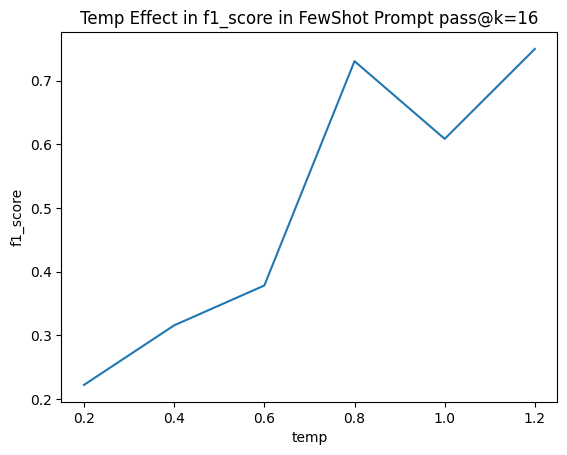

In [64]:
fig = plot_metrics(metric_fs_temp,x_key='temp',y_key='f1_score',title='Temp Effect in f1_score in FewShot Prompt pass@k=16')

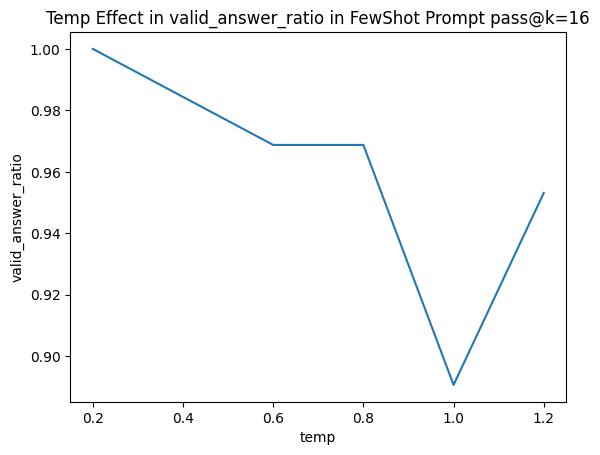

In [65]:
fig = plot_metrics(metric_fs_temp,x_key='temp',y_key='valid_answer_ratio',title='Temp Effect in valid_answer_ratio in FewShot Prompt pass@k=16')

llama_init_from_model: n_ctx_per_seq (8192) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

0.05


running validation set: 100%|██████████| 64/64 [08:36<00:00,  8.07s/it]


0.1


running validation set: 100%|██████████| 64/64 [09:05<00:00,  8.52s/it]


0.15000000000000002


running validation set: 100%|██████████| 64/64 [08:49<00:00,  8.27s/it]


0.2


running validation set: 100%|██████████| 64/64 [08:34<00:00,  8.04s/it]


0.25


running validation set: 100%|██████████| 64/64 [08:07<00:00,  7.61s/it]


0.30000000000000004


running validation set: 100%|██████████| 64/64 [08:06<00:00,  7.61s/it]


0.35000000000000003


running validation set: 100%|██████████| 64/64 [08:43<00:00,  8.18s/it]


0.4


running validation set: 100%|██████████| 64/64 [08:53<00:00,  8.34s/it]


0.45


running validation set: 100%|██████████| 64/64 [08:34<00:00,  8.04s/it]


0.5


running validation set: 100%|██████████| 64/64 [08:52<00:00,  8.31s/it]


0.55


running validation set: 100%|██████████| 64/64 [08:22<00:00,  7.85s/it]


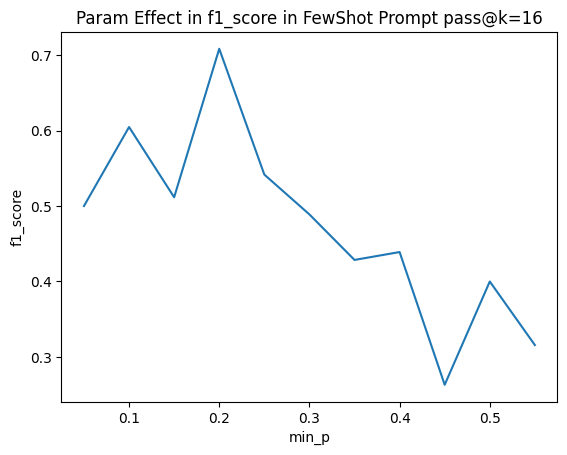

In [66]:
few_shot_exp  = FewShotExperiment(small_model_repo_id, small_model_file_name, n_ctx=1024*8, valid_ds=valid_ds_mini,incoxtext_examples=incontext_ds_small, pass_k=16)
metric_fs_minp = minP_check_helper(few_shot_exp,temp=0.8)
fig = plot_metrics(metric_fs_minp,x_key='min_p',y_key='f1_score',title='Param Effect in f1_score in FewShot Prompt pass@k=16')

llama_init_from_model: n_ctx_per_seq (5120) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

{'accuracy': 0.658051689860835,
 'confusion_matrix': array([[244,  11],
       [161,  87]]),
 'f1_score': 0.5028901734104047,
 'precision': 0.8877551020408163,
 'recall': 0.35080645161290325,
 'valid_answer_ratio': np.float64(0.982421875)}


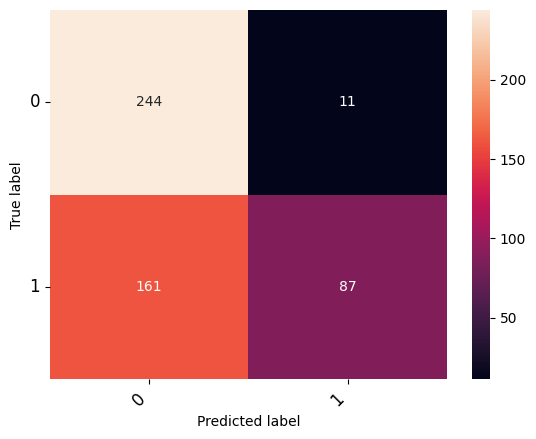

In [68]:
# big val run
few_shot_exp  = FewShotExperiment(small_model_repo_id, small_model_file_name, n_ctx=1024*5, valid_ds=valid_ds_big,incoxtext_examples=incontext_ds_small, pass_k=5)
few_shot_exp.min_p = 0.25
few_shot_exp.temparature = 0.8
few_shot_eval = few_shot_exp().eval()
pprint(few_shot_eval)
fig=utils.plot_cm(few_shot_eval['confusion_matrix'])
fig.savefig('../docs/cm_plot_fewshot_small_valid_big.png')

llama_init_from_model: n_ctx_per_seq (6144) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

{'accuracy': 0.6721311475409836,
 'confusion_matrix': array([[53,  8],
       [32, 29]]),
 'f1_score': 0.5918367346938775,
 'precision': 0.7837837837837838,
 'recall': 0.47540983606557374,
 'valid_answer_ratio': np.float64(0.953125)}


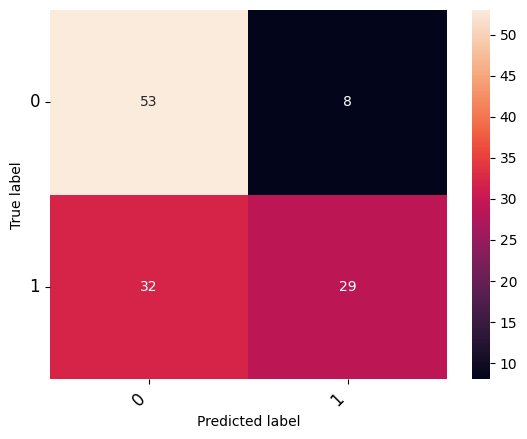

In [22]:
ta_func(few_shot_exp.preds,few_shot_exp.labels)

np.float64(0.6640625)

In [24]:
# # increase pass_k values
# evals = []
# for k in [2,4,10]:
#     few_shot_exp  = FewShotExperiment(small_model_repo_id, small_model_file_name, n_ctx=1024*8, valid_ds=valid_ds_small,incoxtext_examples=incontext_ds_small, pass_k=k)
#     eval = few_shot_exp().eval()
#     eval['pass_k'] = k
#     evals.append(eval)
# # plot 

In [25]:
del few_shot_exp

### Chain of Thought Example

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

0.2


running validation set: 100%|██████████| 64/64 [09:04<00:00,  8.50s/it]


0.4


running validation set: 100%|██████████| 64/64 [05:29<00:00,  5.15s/it]


0.6000000000000001


running validation set: 100%|██████████| 64/64 [05:23<00:00,  5.05s/it]


0.8


running validation set: 100%|██████████| 64/64 [02:05<00:00,  1.96s/it]


1.0


running validation set: 100%|██████████| 64/64 [02:46<00:00,  2.60s/it]


1.2000000000000002


running validation set: 100%|██████████| 64/64 [01:13<00:00,  1.14s/it]


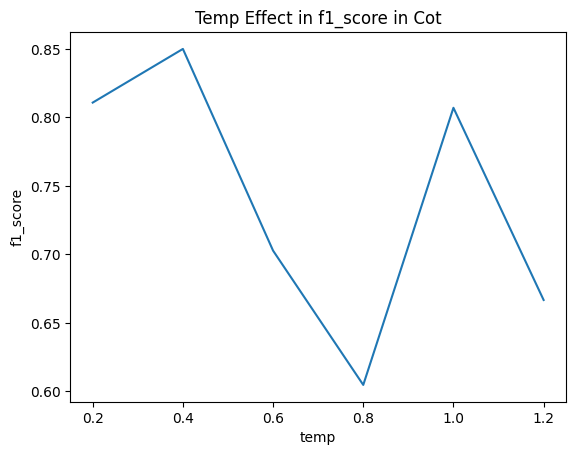

In [70]:
from experiments.cot_experiment import CotExperiment
cot_exp = CotExperiment(repo_id=small_model_repo_id, file_name=small_model_file_name, n_ctx=1024*4, valid_ds=valid_ds_mini)
cot_exp.max_tokens = -1
metric_cot_temp = temp_check_helper(cot_exp)
fig = plot_metrics(metric_cot_temp,x_key='temp',y_key='f1_score',title='Temp Effect in f1_score in Cot')


In [71]:
fig.savefig('../docs/cot_small_temp_param.png')

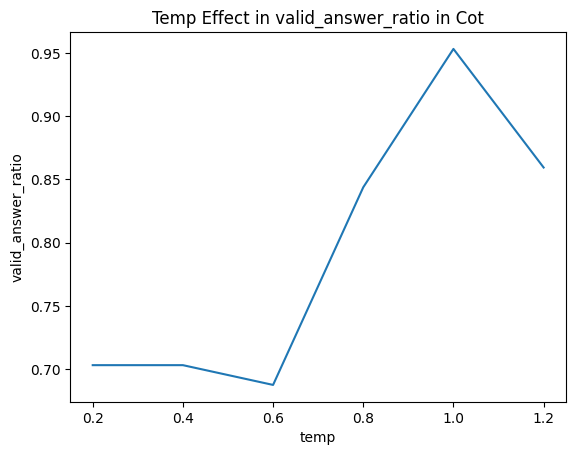

In [73]:
# check invalid
fig_tmp =plot_metrics(metric_cot_temp,x_key='temp',y_key='valid_answer_ratio',title='Temp Effect in valid_answer_ratio in Cot')


In [74]:
# minp experiement for cot
cot_exp = CotExperiment(repo_id=small_model_repo_id, file_name=small_model_file_name, n_ctx=1024*4, valid_ds=valid_ds_mini)
cot_exp.max_tokens = -1
metric_cot_temp = minP_check_helper(cot_exp,temp=0.4)

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_b

0.05


running validation set: 100%|██████████| 64/64 [05:45<00:00,  5.40s/it]


0.1


running validation set: 100%|██████████| 64/64 [08:14<00:00,  7.73s/it]


0.15000000000000002


running validation set: 100%|██████████| 64/64 [08:42<00:00,  8.17s/it]


0.2


running validation set: 100%|██████████| 64/64 [09:50<00:00,  9.22s/it]


0.25


running validation set: 100%|██████████| 64/64 [09:14<00:00,  8.67s/it]


0.30000000000000004


running validation set: 100%|██████████| 64/64 [08:06<00:00,  7.60s/it]


0.35000000000000003


running validation set: 100%|██████████| 64/64 [08:59<00:00,  8.43s/it]


0.4


running validation set: 100%|██████████| 64/64 [10:02<00:00,  9.41s/it]


0.45


running validation set: 100%|██████████| 64/64 [10:56<00:00, 10.26s/it]


0.5


running validation set: 100%|██████████| 64/64 [09:29<00:00,  8.90s/it]


0.55


running validation set:  61%|██████    | 39/64 [07:12<04:37, 11.10s/it]


KeyboardInterrupt: 

In [ ]:
# check min_p
from experiments.cot_experiment import CotExperiment
cot_exp = CotExperiment(repo_id=small_model_repo_id, file_name=small_model_file_name, n_ctx=1024*4, valid_ds=valid_ds_small)
cot_exp.max_tokens = -1
metric_cot_minP = minP_check_helper(cot_exp,temp=0.2)
fig = plot_metrics(metric_cot_minP,x_key='min_p',y_key='f1_score',title='min_p Effect in f1_score in Cot')


array([ 0,  0, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,  0,
       -1,  0,  0,  0,  1,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1, -1, -1,  0,
        0, -1,  0,  0,  1,  0, -1, -1,  0,  0,  0,  0,  0, -1,  0,  0,  1,
       -1,  1,  1,  1,  0,  1, -1, -1,  1,  1, -1,  0,  0,  0, -1,  1, -1,
        1,  1,  0,  1,  0,  0,  0,  1, -1,  1,  1,  1, -1,  0,  1, -1, -1,
       -1, -1,  1,  1, -1, -1,  0,  1,  1, -1, -1,  1, -1, -1,  1,  1,  0,
       -1,  1,  1,  1, -1, -1,  0, -1,  1])

In [13]:
cot_exp.get_run_log()[2]

{'system_promt': 'You are a helpful large language model that understands sentiment of a movie review inside <review>...</review> tags. \nRespond in the following format, using careful step-by-step reasoning.\n<reasoning>\n...\n</reasoning>\n<answer>\n...\n</answer>\nYour answer must be either Negative or Positive',
 'user_prompt': '<review>incredibly intriguing and captivating, i found it impossible to turn away once i began to watch. i am usually one of the harshest critics but to me this film was just brilliant, strange as this may sound i could almost smell the air and feel the textures of the locations. from a cinematographic i thought there was great use of light and texture. from the orange glow of the summer light, down to the plastic wrapped couch all had a distinct air of realism to me.from a character perspective i thought the notion of victor vargas as almost the glue that connects the story was quite inspired, each of the other members of the family having a more complete 

In [14]:
# count length fininsh reason
count = 0
for r in cot_exp.get_run_log():
    if r['response']['choices'][0]['finish_reason'] == 'length':
        count+=1
print(count)

21


### Chain of Thought Example Structural Output